# Atmosphere Phase Screen Gradient

Phase screens are computed with an `Atmosphere` and a `Source` object.
Lets import the `ceo` module first.

In [2]:
import math
import numpy as np
import ceo
import yaml
import matplotlib.pyplot as plt
%matplotlib inline

The atmosphere is defined with

In [3]:
#atm = ceo.Atmosphere(0.15,30,altitude=25,wind_speed=10)
atm =  ceo.GmtAtmosphere(0.15,30,ID=2)

A V band on-axis source is defined first,

In [4]:
NL = 48
NA = NL+1
zen = np.ones(3)*6
azi = np.arange(3)*2*np.pi/3
ngs = ceo.Source('Vs',zenith=zen,azimuth=azi*ceo.constants.ARCMIN2RAD,resolution=(NA,NA))

The telescope pupil is defined as the Giant Magellan Telescope and mask for the deformable mirror actuators is also set.

In [5]:
D = 25.5
#tel = ceo.Telescope(NL*16)
tel = ceo.Telescope(NL*16,D)
tel = ceo.GMT(NL*16,D)
dm  = ceo.Mask(NA,D)

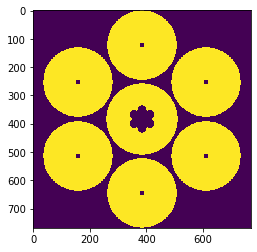

In [6]:
plt.imshow(tel.f.host(shape=(NL*16,NL*16)),interpolation='None')

A `Centroiding` object is defined, it will contains the phase screen gradient.
The `fried_geometry` method computes the DM valid actuator mask according to the telescope pupil shape and the given intensity `threshlod`.
The `Source` object is masked with the dm mask.

In [7]:
d = D/NL
cog = ceo.Centroiding(NL,ngs.N_SRC)
cog.fried_geometry(dm, tel, 16, 0.5)
ngs.masked(dm)

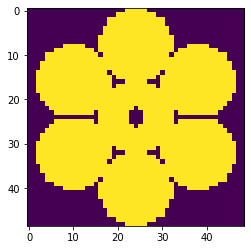

In [8]:
plt.imshow(dm.f.host(shape=(NA,NA)),interpolation='None')

The $n \times n$ phase screen of $D$ width is computed next

In [9]:
data = np.loadtxt("/home/rconan/projects/gicsdom/KPP_field_sampler.csv",delimiter=',',skiprows=1)
zen_sc = data[:,0]
azi_sc = data[:,1]*np.pi/180

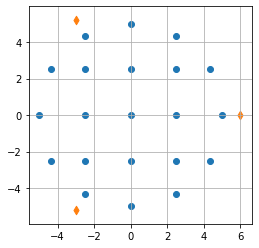

In [10]:
fig,ax = plt.subplots()
x = zen_sc*np.cos(azi_sc)
y = zen_sc*np.sin(azi_sc)
ax.scatter(x,y)
x = zen*np.cos(azi)
y = zen*np.sin(azi)
ax.scatter(x,y,marker='d')
ax.grid()
ax.set_aspect('equal')

In [11]:
#zen = np.ones(3)*ceo.constants.ARCMIN2RAD*6
#azi = np.arange(3)*2*np.pi/3
src = ceo.Source('Vs',zenith=zen_sc*ceo.constants.ARCMIN2RAD,azimuth=azi_sc,resolution=(NA,NA))

In [12]:
dm_mask = dm.f
src.masked(dm)

In [13]:
p = D/(NA-1)
atm.get_phase_screen(src,p,NA,p,NA,0.0)
src_phase = src.phase.host(units='micron')#,zm=True,mask=dm_mask.host())

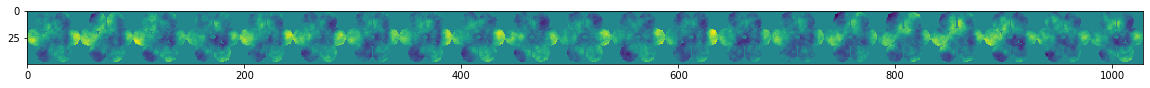

In [14]:
fig,ax=plt.subplots(figsize=(20,4))
ax.imshow(src_phase.T)

The phase screen gradient is computed with the `Atmosphere` method `get_phase_screen_gradient`.
The gradient is computed over a square lenslet array of size $N_L \times N_L$ with $d$ the pitch in meter.
The phase screen gradient is computed for a given `Source` object that contains one or more guide stars.
The phase screen gradient can be computed for a given time delay.
The $c_x$ and $c_y$ centroids are saved in a `Centroiding` object.

In [15]:
atm.get_phase_screen_gradient(cog,NL,d,ngs,0.0)
c = cog.c.host(units='arcsec')

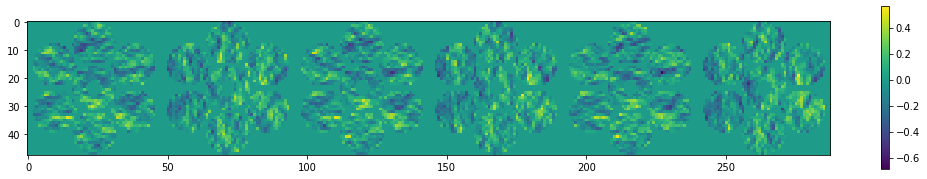

In [16]:
fig,ax = plt.subplots(figsize=(18,3))
h = ax.imshow(np.hstack(np.vsplit(c.reshape(NL*2*ngs.N_SRC,NL),ngs.N_SRC*2)))
fig.colorbar(h,ax=ax)

From the phase gradient, the phase screen can be reconstructed with a linear minimim mean square error reconstructor (LMMSE).
A `Lmmse` object is used to perform the phase estimation.
The parameters are:
- an `Atmosphere` object,
- a `Source` object representing the guide star(s),
- the number of guide stars,
- a `Source` object representing the star(s) in the estimation direction(s),
- the number of star(s) in the estimation direction(s),
- the wavefront sampling step in meter,
- the number of sample across the wavefront,
- a `Mask` object representing the pupil,
- the iterative solver.

In [17]:
src0 = ceo.Source('Vs',resolution=(NA,NA))
src0.masked(dm)
atm.get_phase_screen(src0,p,NA,p,NA,0.0)
src0_phase = src0.phase.host(units='micron',zm=True,mask=dm_mask.host())

In [18]:
print("Fitting error: {:.0f}nm".format(np.sqrt(0.335*(D/atm.r0)**(5/3)*(NA**2*np.pi/4)**(-5/6))*500/2/np.pi))

Fitting error: 144nm


In [24]:
palmmse = ceo.ALmmse(atm,ngs,ceo.constants.ARCMIN2RAD*2.5,d,NL,dm,"MINRES")
palmmse.estimation(cog)
palmmse_phase = palmmse.phase.host(units='micron',zm=True,mask=dm_mask.host())

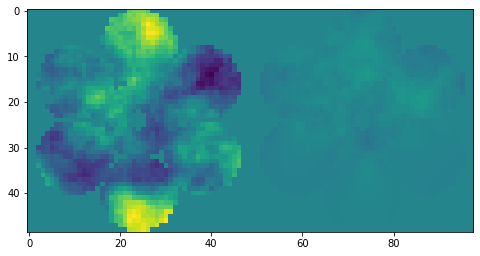

In [25]:
fig,ax = plt.subplots(figsize=(8,10))
h = ax.imshow(np.hstack([src0_phase,palmmse_phase]))

In [26]:
m = dm_mask.host().ravel()==1

In [27]:
1e3*src_phase.reshape(-1,NA*NA)[:,m].std(-1)

array([1741.76  , 1909.583 , 1788.216 , 1566.7145, 1802.1776, 1803.2291,
       1659.0085, 1833.5448, 1784.5626, 1776.1746, 1592.1941, 1704.3131,
       1870.006 , 1588.8499, 1571.5142, 1787.5775, 1818.0304, 1929.0292,
       2084.9917, 1587.3269, 1695.9591], dtype=float32)

In [28]:
1e3*(src_phase.reshape(-1,49*49)-palmmse_phase.reshape(-1,NA*NA))[:,m].std(-1)

array([1693.0585, 1862.3323, 1737.8359, 1519.1901, 1770.9525, 1725.7162,
       1637.6705, 1797.0176, 1732.155 , 1700.968 , 1530.5256, 1669.8876,
       1866.779 , 1558.1472, 1537.1808, 1754.5133, 1789.6329, 1890.915 ,
       2003.7772, 1538.4241, 1651.0073], dtype=float32)